Testing a Hybrid approach by using linear regression to determine trend and XGBoost to predict on residuals.

# Requirements

In [32]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

# Data Loading

In [11]:
df_baseline = pd.read_csv("/content/drive/MyDrive/CentraleSupelec/3A/BCG_datathon/Data/clean_baseline.csv",delimiter=";")
df_baseline["Date et heure de comptage"]=pd.to_datetime(df_baseline["Date et heure de comptage"], format="%Y-%m-%d %H:%M:%S")

df_baseline.head(5)

,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Etat arc_Barré,Etat arc_Invalide
0,AV_Champs_Elysees,2022-01-01 11:00:00,524.0,8.85667,1,0,1
1,AV_Champs_Elysees,2022-01-01 07:00:00,491.0,7.71611,1,0,1
2,AV_Champs_Elysees,2022-01-01 19:00:00,997.0,46.28889,3,0,1
3,AV_Champs_Elysees,2022-01-01 18:00:00,1096.0,46.60222,3,0,1
4,AV_Champs_Elysees,2022-01-01 09:00:00,258.0,3.75445,1,0,1


In [3]:
df_chmps = df_baseline[df_baseline["Libelle"]=="AV_Champs_Elysees"]
df_sts = df_baseline[df_baseline["Libelle"]=="Sts_Peres"]
df_cnvtn = df_baseline[df_baseline["Libelle"]=="Convention"]

# Util functions

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
def rmse(y_true,y_pred):
  return np.sqrt(mean_squared_error(y_true,y_pred))

# Champs Elysées

In [26]:
df_chmps_base = df_chmps.drop(columns=["Libelle","Etat trafic","Etat arc_Barré", "Etat arc_Invalide"])
df_chmps_base.sort_values(by="Date et heure de comptage", inplace=True)
df_chmps_base.set_index("Date et heure de comptage",inplace=True)
df_chmps_base

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2021-11-01 04:00:00,1222.0,42.87945
2021-11-01 05:00:00,1033.0,44.35278
2021-11-01 06:00:00,824.0,20.16222
2021-11-01 07:00:00,710.0,12.20000
2021-11-01 08:00:00,947.0,40.57222
...,...,...
2022-12-03 20:00:00,1178.0,35.10778
2022-12-03 21:00:00,1107.0,46.05833
2022-12-03 22:00:00,1256.0,33.02056


### Trend

In [55]:
y = df_chmps_base.copy()

# Create trend features
dp = DeterministicProcess(
    index = y.index,
    constant=True,
    order=1,
    drop=True
)
X = dp.in_sample()

In [48]:
X

,const,trend
Date et heure de comptage,,
2021-11-01 04:00:00,1.0,1.0
2021-11-01 05:00:00,1.0,2.0
2021-11-01 06:00:00,1.0,3.0
2021-11-01 07:00:00,1.0,4.0
2021-11-01 08:00:00,1.0,5.0
...,...,...
2022-12-03 20:00:00,1.0,9182.0
2022-12-03 21:00:00,1.0,9183.0
2022-12-03 22:00:00,1.0,9184.0


In [49]:
X_train,X_test,y_train,y_test = timeseries_train_test_split(X, y, test_size=0.3)

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


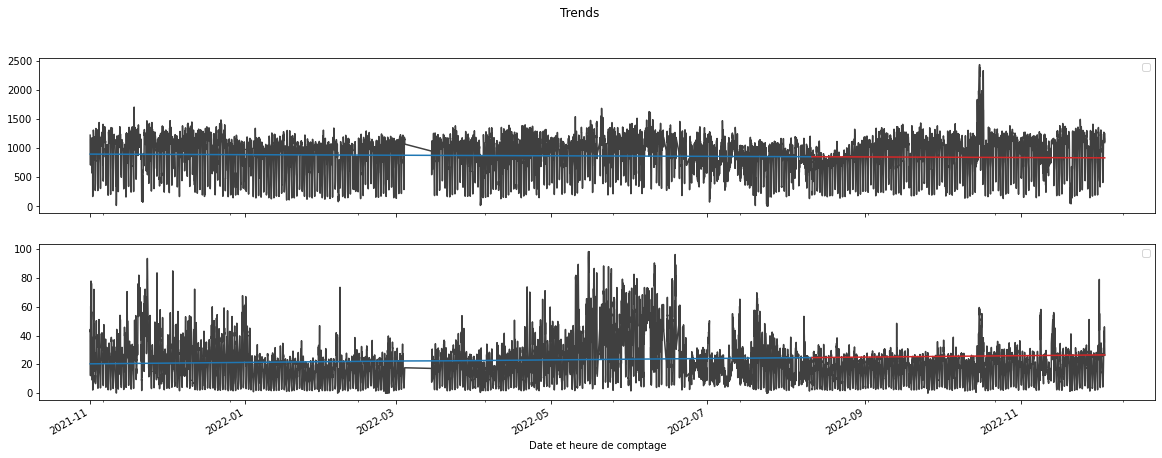

In [50]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(X_train,y_train)

y_trend_fit = pd.DataFrame(
    linear_model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)

y_trend_pred = pd.DataFrame(
    linear_model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_trend_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_trend_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")


In [53]:
y

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2021-11-01 04:00:00,1222.0,42.87945
2021-11-01 05:00:00,1033.0,44.35278
2021-11-01 06:00:00,824.0,20.16222
2021-11-01 07:00:00,710.0,12.20000
2021-11-01 08:00:00,947.0,40.57222
...,...,...
2022-12-03 20:00:00,1178.0,35.10778
2022-12-03 21:00:00,1107.0,46.05833
2022-12-03 22:00:00,1256.0,33.02056


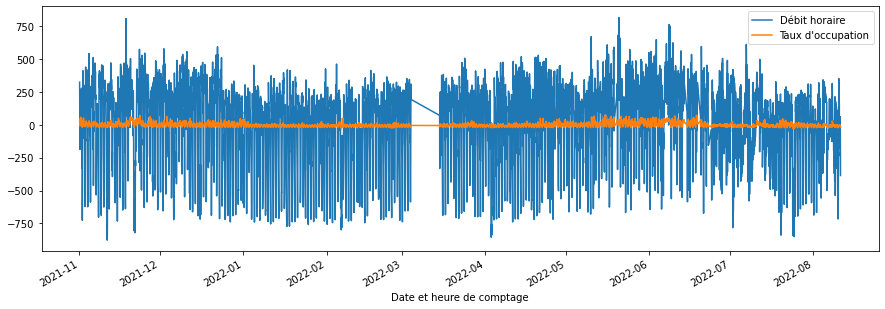

In [89]:
# We remove the trend

y_detrended = y_train - y_trend_fit
y_detrended.plot(figsize=(15,5))

In [91]:
y_detrended_test = y_test - y_trend_pred


### Seasonality

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


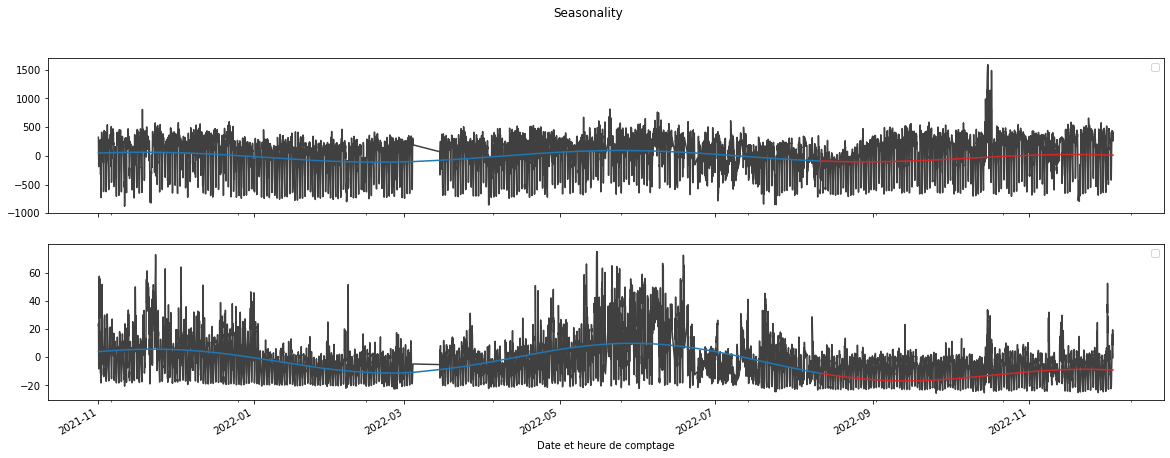

In [92]:


# Let's now look at seasonality

fourier = CalendarFourier(freq="A", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp_season = DeterministicProcess(
    index=y.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_season = dp_season.in_sample() 

X_train_season,X_test_season,y_train,y_test = timeseries_train_test_split(X_season, y, test_size=0.3)

linear_model_season = LinearRegression(fit_intercept=False)
linear_model_season.fit(X_train_season,y_detrended)

y_season_fit = pd.DataFrame(
    linear_model_season.predict(X_train_season),
    index=y_train.index,
    columns=y_train.columns,
)

y_season_pred = pd.DataFrame(
    linear_model_season.predict(X_test_season),
    index=y_test.index,
    columns=y_test.columns,
)

# Plot
axs = y_detrended.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_detrended_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_season_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_season_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Seasonality")

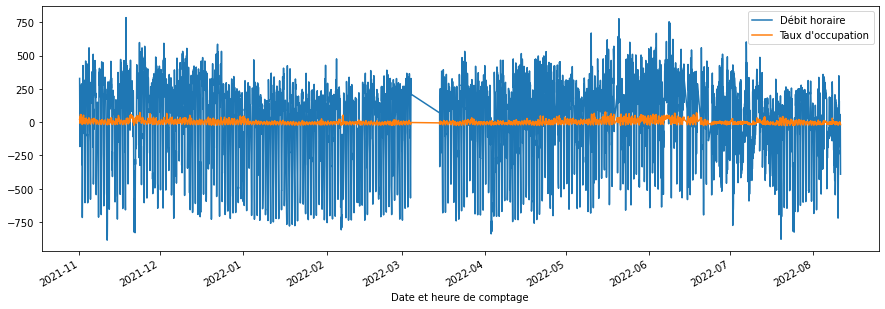

In [97]:
y_deseasoned = y_detrended - y_season_fit
y_deseasoned.plot(figsize=(15,5))

In [104]:
y_deseasoned_test = y_detrended_test - y_season_pred


### Cycles

In [109]:
y_deseasoned_total = pd.concat([y_deseasoned,y_deseasoned_test])
y_deseasoned_total

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2021-11-01 04:00:00,328.024832,22.554736
2021-11-01 05:00:00,139.262187,24.045917
2021-11-01 06:00:00,-69.491999,-0.126532
2021-11-01 07:00:00,-183.237922,-8.070383
2021-11-01 08:00:00,54.024202,20.320461
...,...,...
2022-12-03 20:00:00,357.276212,10.193429
2022-12-03 21:00:00,286.079589,21.158599
2022-12-03 22:00:00,434.876929,8.134771


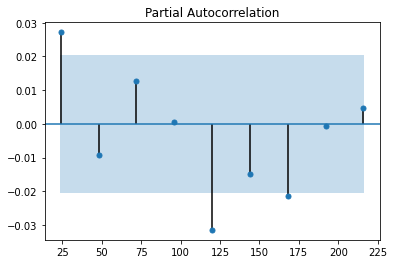

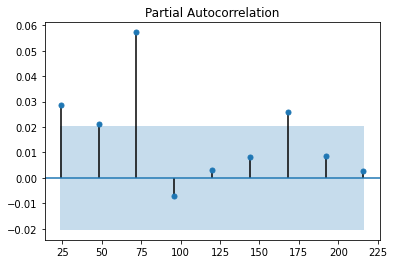

In [114]:
from statsmodels.graphics.tsaplots import plot_pacf

_ = plot_pacf(y_deseasoned_total["Débit horaire"],lags=[24*i for i in range(1,10)])
_ = plot_pacf(y_deseasoned_total["Taux d'occupation"],lags=[24*i for i in range(1,10)])

In [118]:
 y_deseasoned_total["Débit horaire"]

Date et heure de comptage
2021-11-01 04:00:00    328.024832
2021-11-01 05:00:00    139.262187
2021-11-01 06:00:00    -69.491999
2021-11-01 07:00:00   -183.237922
2021-11-01 08:00:00     54.024202
                          ...    
2022-12-03 20:00:00    357.276212
2022-12-03 21:00:00    286.079589
2022-12-03 22:00:00    434.876929
2022-12-03 23:00:00    367.668467
2022-12-04 00:00:00    274.454442
Name: Débit horaire, Length: 9186, dtype: float64

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


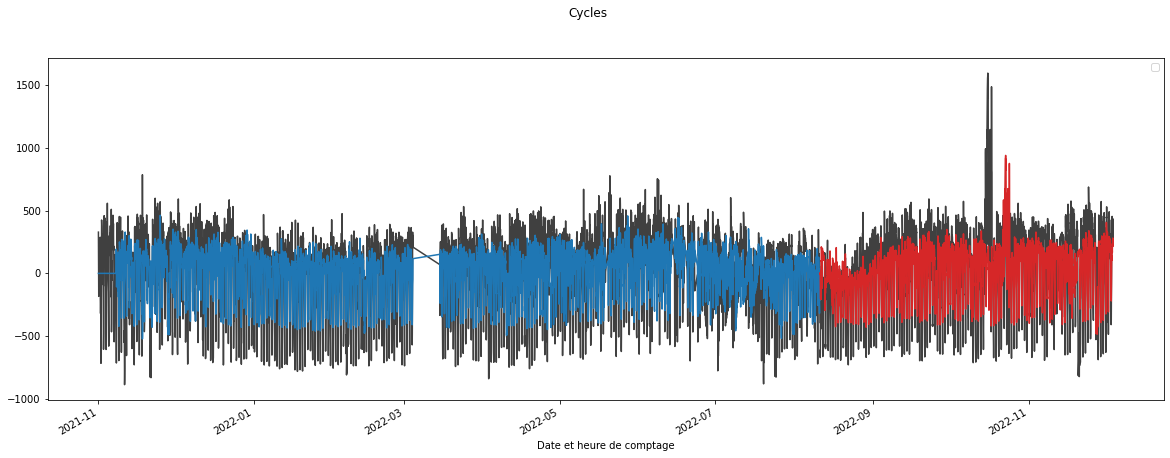

In [122]:
X_lag_debit = pd.concat([y_deseasoned_total["Débit horaire"].shift(24*7)],axis=1)
X_lag_debit  = X_lag_debit.fillna(0.0)

y_cycle_debit = y_deseasoned_total["Débit horaire"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_debit_train, X_lag_debit_test, y_cycle_debit_train, y_cycle_debit_test = timeseries_train_test_split(X_lag_debit,y_cycle_debit, test_size=0.3) 

linear_model_cycle.fit(X_lag_debit_train,y_cycle_debit_train)

y_cycle_debit_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_train),
    index = y_cycle_debit_train.index,
    columns = ["Débit horaire"],
)

y_cycle_debit_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_debit_test),
    index = y_cycle_debit_test.index,
    columns = ["Débit horaire"],
)

axs = y_cycle_debit_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_debit_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_debit_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


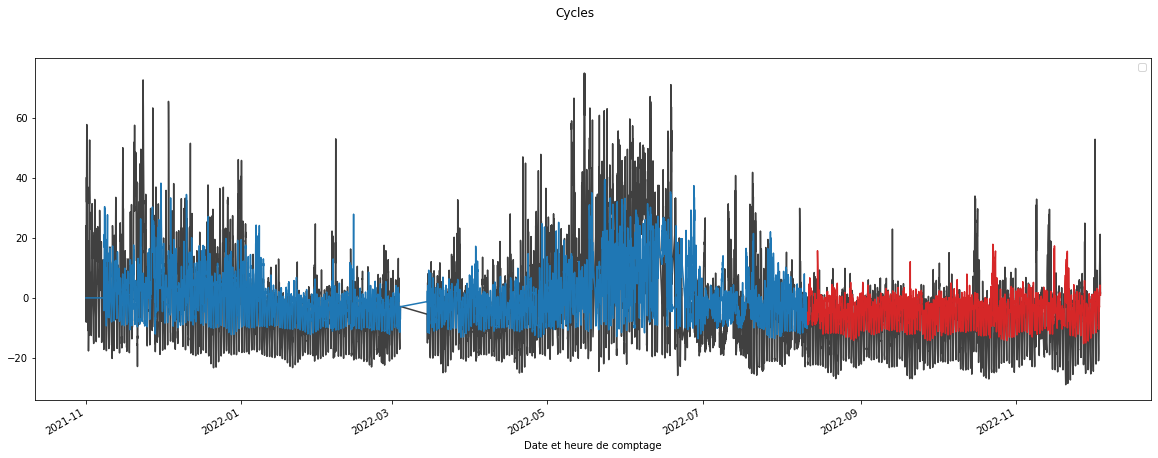

In [126]:
X_lag_taux = pd.concat([y_deseasoned_total["Taux d'occupation"].shift(24*7)],axis=1)
X_lag_taux  = X_lag_taux.fillna(0.0)

y_cycle_taux = y_deseasoned_total["Taux d'occupation"].copy()

linear_model_cycle = LinearRegression(fit_intercept=False)

X_lag_taux_train, X_lag_taux_test, y_cycle_taux_train, y_cycle_taux_test = timeseries_train_test_split(X_lag_taux,y_cycle_taux, test_size=0.3) 

linear_model_cycle.fit(X_lag_taux_train,y_cycle_taux_train)

y_cycle_taux_fit = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_train),
    index = y_cycle_taux_train.index,
    columns = ["Taux d'occupation"],
)

y_cycle_taux_pred = pd.DataFrame(
    data = linear_model_cycle.predict(X_lag_taux_test),
    index = y_cycle_taux_test.index,
    columns = ["Taux d'occupation"],
)

axs = y_cycle_taux_train.plot(color='0.25', subplots=True, sharex=True, figsize=(20,7))
axs = y_cycle_taux_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_cycle_taux_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])
_ = plt.suptitle("Cycles")


In [129]:
y_cycle_debit_fit

,Débit horaire
Date et heure de comptage,
2021-11-01 04:00:00,0.000000
2021-11-01 05:00:00,0.000000
2021-11-01 06:00:00,0.000000
2021-11-01 07:00:00,0.000000
2021-11-01 08:00:00,0.000000
...,...
2022-08-10 23:00:00,31.116571
2022-08-11 00:00:00,-47.456827
2022-08-11 01:00:00,-196.406707


In [135]:
y_deseasoned_debit = y_deseasoned.drop(columns=["Taux d'occupation"])
y_deseasoned_taux = y_deseasoned.drop(columns=["Débit horaire"])

y_deseasoned_debit_test = y_deseasoned_test.drop(columns=["Taux d'occupation"])
y_deseasoned_taux_test = y_deseasoned_test.drop(columns=["Débit horaire"])

In [136]:
y_residual_debit_train = y_deseasoned_debit - y_cycle_debit_fit
y_residual_debit_test = y_deseasoned_debit_test - y_cycle_debit_pred

y_residual_taux_train = y_deseasoned_taux - y_cycle_taux_fit
y_residual_taux_test = y_deseasoned_taux_test - y_cycle_taux_pred

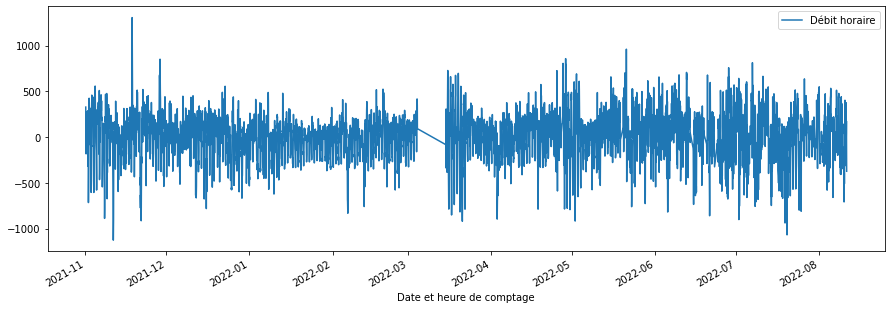

In [139]:
y_residual_debit_train.plot(figsize=(15,5))

### Trend + season + cycles

In [140]:
y_trend_pred

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2022-08-11 04:00:00,852.641968,24.722261
2022-08-11 05:00:00,852.635012,24.722936
2022-08-11 06:00:00,852.628056,24.723611
2022-08-11 07:00:00,852.621100,24.724286
2022-08-11 08:00:00,852.614144,24.724960
...,...,...
2022-12-03 20:00:00,833.505811,26.578384
2022-12-03 21:00:00,833.498854,26.579059
2022-12-03 22:00:00,833.491898,26.579733


In [141]:
y_season_pred

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2022-08-11 04:00:00,11.822467,-0.158120
2022-08-11 05:00:00,11.920321,-0.140423
2022-08-11 06:00:00,12.015321,-0.122804
2022-08-11 07:00:00,12.107287,-0.105275
2022-08-11 08:00:00,12.196040,-0.087849
...,...,...
2022-12-03 20:00:00,-12.782022,-1.664033
2022-12-03 21:00:00,-12.578443,-1.679328
2022-12-03 22:00:00,-12.368827,-1.693944


In [142]:
y_cycle_taux_pred

,Taux d'occupation
Date et heure de comptage,
2022-08-11 04:00:00,-4.867043
2022-08-11 05:00:00,-4.821540
2022-08-11 06:00:00,-8.921757
2022-08-11 07:00:00,-8.886256
2022-08-11 08:00:00,-8.850966
...,...
2022-12-03 20:00:00,4.268260
2022-12-03 21:00:00,1.532768
2022-12-03 22:00:00,1.768369


In [144]:
y_cycle_pred = pd.concat([y_cycle_taux_pred,y_cycle_debit_pred],axis=1)
y_cycle_pred

,Taux d'occupation,Débit horaire
Date et heure de comptage,,
2022-08-11 04:00:00,-4.867043,-5.069081
2022-08-11 05:00:00,-4.821540,7.115272
2022-08-11 06:00:00,-8.921757,-199.588084
2022-08-11 07:00:00,-8.886256,-201.115763
2022-08-11 08:00:00,-8.850966,-202.652487
...,...,...
2022-12-03 20:00:00,4.268260,213.015776
2022-12-03 21:00:00,1.532768,267.477666
2022-12-03 22:00:00,1.768369,236.517329


In [145]:
y_pred_deterministic = y_trend_pred + y_season_pred + y_cycle_pred 
y_pred_deterministic

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2022-08-11 04:00:00,859.395354,19.697098
2022-08-11 05:00:00,871.670605,19.760973
2022-08-11 06:00:00,665.055293,15.679049
2022-08-11 07:00:00,663.612624,15.732754
2022-08-11 08:00:00,662.157697,15.786145
...,...,...
2022-12-03 20:00:00,1033.739564,29.182610
2022-12-03 21:00:00,1088.398078,26.432498
2022-12-03 22:00:00,1057.640400,26.654158


In [147]:
X = df_chmps_base
y = df_chmps_base

_,_,_,y_test = timeseries_train_test_split(X,y,test_size=0.3)

In [148]:
y_test

,Débit horaire,Taux d'occupation
Date et heure de comptage,,
2022-08-11 04:00:00,253.0,3.01833
2022-08-11 05:00:00,195.0,2.32833
2022-08-11 06:00:00,245.0,2.89611
2022-08-11 07:00:00,460.0,5.88000
2022-08-11 08:00:00,580.0,8.00167
...,...,...
2022-12-03 20:00:00,1178.0,35.10778
2022-12-03 21:00:00,1107.0,46.05833
2022-12-03 22:00:00,1256.0,33.02056


In [149]:
rmse(y_test,y_pred_deterministic)

186.85288708808045